In [57]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import numpy as geek 

In [8]:
#Upload Text File with Data
#This must be altered with appropriate directory, based on respective meaturement setup, and respective timezone

columns = ["Datetime","Date","Time","Temp 1","Temp 2","Temp 3","Temp 4","Temp 5","Voc","Irradiance"]
df = pd.read_table(r"C:\Users\17572\Dropbox (Personal)\Journal 1\Jupyter Notebooks\Updated Testing\dataloglowlight.txt", delimiter =",", header = None, names = columns)
df.Date = [datetime.strptime(x,'%Y/%m/%d') for x in df.Date]
df.Time = [datetime.strptime(y,'%H:%M:%S') for y in df.Time]
df['Datetime'] = [datetime.fromtimestamp(x) for x in df['Datetime']]
df['Time'] = df['Time'].dt.time
df['Temp Avg'] = df[['Temp 1', 'Temp 2', 'Temp 3', 'Temp 4', 'Temp 5']].mean(axis = 1)
df.index = df['Datetime']
df.index = df.index.tz_localize(tz='UTC')
df.index = df.index.tz_convert('US/Arizona')

In [9]:
#Get Cell Temp from backsheet using King Paper (Photovoltaic Array Performance Model) with Delta T chosen of 3
df['Cell Temp'] = df['Temp Avg']+df['Irradiance']*3

In [5]:
#filter out times that are night, sunrise, sunset, etc. For whatever analysis is trying to be performed.

starttime =  '18:00:00'
endtime = '22:00:00'

df_filtered = df.between_time(starttime, endtime)

<ipython-input-6-26a042f26583>:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000275C0ABF460> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(p, [p_.get_label() for p_ in p], loc = 'best')
<ipython-input-6-26a042f26583>:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000275C0AB3F10> has a label of '_line1' which cannot be automatically added to the legend.
  ax.legend(p, [p_.get_label() for p_ in p], loc = 'best')
<ipython-input-6-26a042f26583>:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000275C0ABF490> has a label of '_line0' which cannot be automatically added to the legend.
  ax.legend(p, [p_.get_label() for p_ in p], loc = 'best')


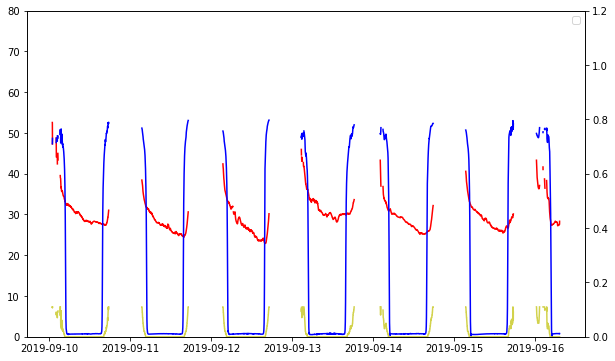

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

#downsample to minutely, makes it faster to plot
df2 = df.resample('T').mean()
#ax.plot(df2.index, df2['Temp 1'])
#ax.plot(df2.index, df2['Temp 2'])
#ax.plot(df2.index, df2['Temp 3'])
#ax.plot(df2.index, df2['Temp 4'])
#ax.plot(df2.index, df2['Temp 5'])

ax2 = ax.twinx()
a, = ax.plot(df2.index, df2['Cell Temp'],'-r')
b, = ax.plot(df2.index, df2['Voc'], '-b')
c, =ax2.plot(df2.index, df2['Irradiance'], '-y', alpha = 0.7)
p = [a, b, c]
ax.set_ylim([0, 80])
ax2.set_ylim([0, 1.2])
ax.legend(p, [p_.get_label() for p_ in p], loc = 'best')

plt.show()

In [7]:
df2['Cell Temp'].mean()

29.360118968397632

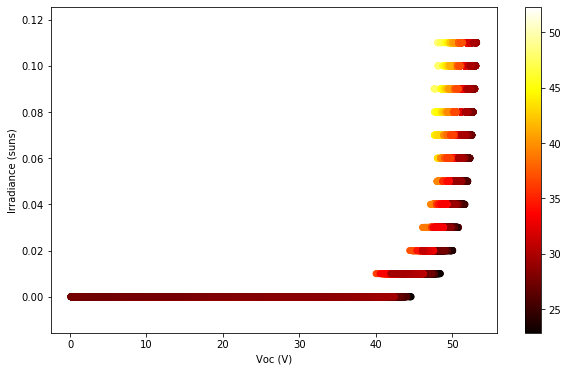

In [11]:
#Plot Voc vs Irradiance w/o any temperature correction

fig, ax = plt.subplots(figsize=(10,6))
df_filtered = df[df['Irradiance'] >= 0.0] #Filter out irradiance range of interest
plot1 = ax.scatter(df_filtered['Voc'], df_filtered['Irradiance'], c = df_filtered['Temp Avg'], cmap = 'hot')
ax.set_xlabel('Voc (V)')
ax.set_ylabel('Irradiance (suns)')
fig.colorbar(plot1, ax = ax)
plt.show()


In [19]:
#fit equation of form:
#VOC = β0 + β1 · T · ln(Ir)+ β2 · T + β3 · T · ln(T)
#to voc

def voc_func1(x, beta1, beta2, beta3):
    irradiance, temperature = x
    voc = beta1 + beta2*np.log(irradiance) + beta3*(temperature)
    return voc

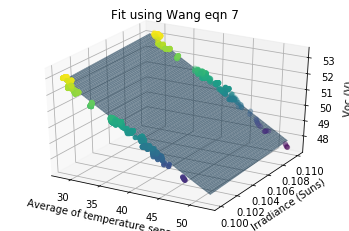

In [22]:
#Plot Voc vs Temp vs Irradiance compared to fit

df_selected = df[df['Irradiance'] >= 0.1] #Filter out irradiance range of interest
df_filtered = df[df['Irradiance'] >= 0.1] #Filter out irradiance range of interest

beta1 = 96*.6
beta2 = np.exp(1)
beta3 = -0.002*96
p0 = (beta1, beta2, beta3)
irradiance = df_selected['Irradiance']
temp = df_selected['Temp Avg']

fitted_parameters, pcov = curve_fit(voc_func1, (irradiance,temp), df_selected['Voc'], p0 = p0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xModel = np.linspace(min(df_filtered['Irradiance']), max(df_filtered['Irradiance']))
yModel = np.linspace(min(df_filtered['Temp Avg']), max(df_filtered['Temp Avg']))
X, Y = np.meshgrid(xModel, yModel)

Z = voc_func1(np.array([X,Y]), fitted_parameters[0], fitted_parameters[1], fitted_parameters[2])
ax.plot_surface(Y,X,Z, alpha = 0.6)

ax.scatter(temp, irradiance, df_selected['Voc'], c = df_selected['Voc'])

ax.set_zlabel('Voc (V)')
ax.set_xlabel('Average of temperature sensors (C)')
ax.set_ylabel('Irradiance (Suns)')
ax.set_title("Translation")
plt.show()

In [23]:
#Print coefficients
fitted_parameters

array([66.03982319,  2.9825368 , -0.22297196])

In [26]:
#Print VOC at specific irradiance and temp (1,25) corresponds to 1 sun and 25 C

voc_func1((1,25),fitted_parameters[0], fitted_parameters[1],fitted_parameters[2])

60.46552418164132

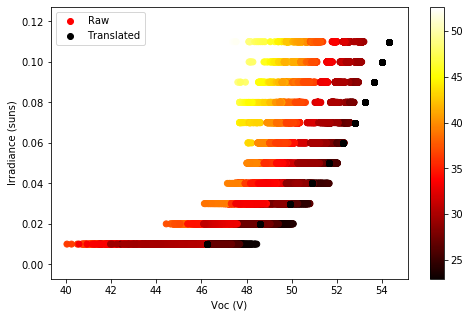

In [53]:
#Graph raw data and translated data

fig, ax = plt.subplots(figsize=(8,5))
df_filtered = df[(df['Irradiance'] >= 0.001) & (df['Irradiance'] <= 1.10)] #filer irradiance region of interest
df_filtered = df[(df['Cell Temp'] >= 0) & (df['Cell Temp'] <= 80)] #filer temperature region of interest
df_filtered = df_filtered[(df_filtered['Irradiance'] >= 0.001) & (df_filtered['Irradiance'] <= 1.10)]
df_high_irradiance = df[df['Irradiance'] >= 0.10]

#plot raw data
plot = ax.scatter(df_filtered['Voc'], df_filtered['Irradiance'], label = 'Raw', c = df_filtered['Cell Temp'], cmap = 'hot')

#translate via VOC = β1 + β2 × ln(Ir)+ β3 × T
beta1 = 96*.6 #96 represents the number of cells in module
n= 1
k = 1.38066E-23 #(J/K) 
q = 1.60218E-19 #C
beta2 = (n*k*(273.15+45)/q)*96
beta3 = -0.002*96

p0 = (beta1, beta2, beta3)
irradiance = df_filtered['Irradiance']
temp = df_filtered['Cell Temp']
fitted_parameters, pcov = curve_fit(voc_func1, (irradiance,temp), df_filtered['Voc'], p0 = p0)
voc_func1_result = []
for i in df_filtered['Irradiance']:
    voc = voc_func1((i,25),fitted_parameters[0],fitted_parameters[1],fitted_parameters[2]) #25 represents temperature being translated to
    voc_func1_result.append(voc)

ax.scatter(voc_func1_result, df_filtered['Irradiance'], label = 'Translated', c ='black')

ax.set_xlabel('Voc (V)')
ax.set_ylabel('Irradiance (suns)')
cbar = fig.colorbar(plot, ax = ax)
ax.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
plt.show()

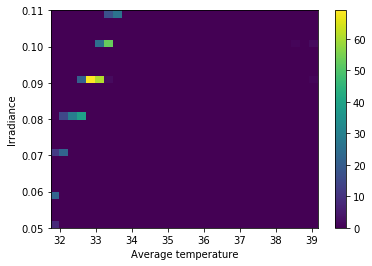

In [32]:
#Plot irradiance against avg temperature

fig, ax = plt.subplots()
starttime =  '18:00:00' #
endtime = '22:00:00'
df_filtered = df.between_time(starttime, endtime)

hist = ax.hist2d(df_filtered['Cell Temp'], df_filtered['Irradiance'], bins = 30)
ax.set_xlabel('Average temperature')
ax.set_ylabel('Irradiance')
fig.colorbar(hist[3], ax=ax)

plt.show()

In [62]:
#Prepare data for ideality factor and pFF calculation
#Can filter data to provide calculation at different light intensities and temperatures
z = np.column_stack((voc_func1_result, irradiance))
idea = pd.DataFrame(data=z, columns=["Voc", "Irradiance"])
idea.sort_index(axis=1, ascending=False)

,Voc,Irradiance
0,54.323573,0.11
1,54.323573,0.11
2,54.323573,0.11
3,54.323573,0.11
4,54.323573,0.11
...,...,...
16444,46.243941,0.01
16445,46.243941,0.01
16446,46.243941,0.01
16447,46.243941,0.01


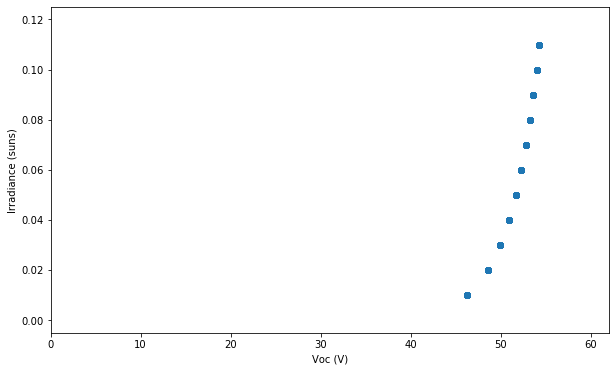

In [64]:
#Plot data before log
fig, ax = plt.subplots(figsize=(10,6))
plot1 = ax.scatter(idea['Voc'], idea['Irradiance'])
ax.set_xlim([0, 62])
ax.set_xlabel('Voc (V)')
ax.set_ylabel('Irradiance (suns)')

plt.show()

In [65]:
idea['Irradiance'] = np.log(idea['Irradiance'])

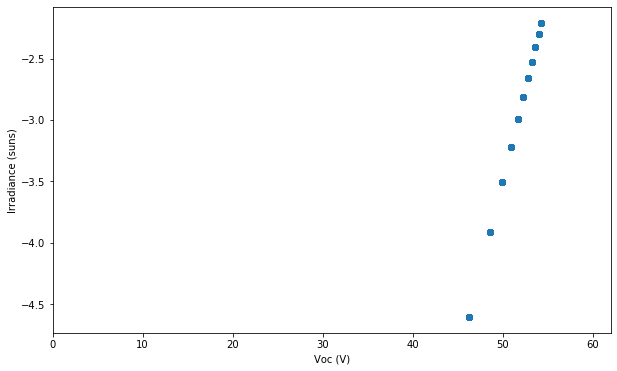

In [66]:
#Plot data after log
fig, ax = plt.subplots(figsize=(10,6))
plot1 = ax.scatter(idea['Voc'], idea['Irradiance'])
ax.set_xlim([0, 62])
ax.set_xlabel('Voc (V)')
ax.set_ylabel('Irradiance (suns)')

plt.show()

In [68]:
#calculate ideality factor
idea_filtered = idea[(idea['Voc'] >= 54)] #filter out region of interest
fit = np.polyfit(idea_filtered['Voc'],idea_filtered['Irradiance'],1)
plot_fit = np.polyval(fit,(45,62))

k = 1.38066E-23 #(J/K) 
q = 1.60218E-19
t = 25 
num = 96 #number of cells
beta = (k*(273.15+t)/q)*num

n = 1/fit[0]/beta
n

1.3660918364689003

In [70]:
#Calculate pFF

y = voc_func1((1,t),fitted_parameters[0], fitted_parameters[1],fitted_parameters[2]) #calculate voc at 1 sun
x = (q/(n*k*(273.15+t)))*(y/num)
FF = (x-np.log(x+0.72))/(x+1)
FF

0.7958027994708626